<a href="https://colab.research.google.com/github/julesripoll/contrastive-learning/blob/main/Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.6 MB/s 


In [2]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 5.4 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import csv
import os
import PIL
from PIL import Image
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from numpy.random import randint
import tensorflow as tf
from tensorflow import keras
import albumentations as A
A.__version__

'1.1.0'

In [4]:
!git clone https://github.com/axelcarlier/projsemisup.git
path = "./projsemisup/"

Cloning into 'projsemisup'...
remote: Enumerating objects: 10798, done.
remote: Total 10798 (delta 0), reused 0 (delta 0), pack-reused 10798
Receiving objects: 100% (10798/10798), 328.98 MiB | 24.03 MiB/s, done.
Checking out files: 100% (11563/11563), done.


In [5]:
CLASSES = []
with open(path + 'selected_classes.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=',', quotechar='"')
	for row in filereader:
		CLASSES.append(row[0])

print(CLASSES)

['red fox', 'gray wolf', 'snail', 'lizard', 'spider', 'turtle', 'hippopotamus', 'mosquito', 'crocodile', 'oyster', 'ant', 'american black bear', 'grizzly bear', 'chicken', 'beluga whale', 'humpback whale', 'tiger shark', 'dolphin', 'eagle', 'deer', 'parrot', 'falcon', 'snake', 'king penguin', 'giant panda', 'giraffe', 'donkey', 'sheep', 'salamander', 'wombat', 'bee', 'bat', 'rabbit', 'rooster', 'guinea pig', 'pig', 'goats', 'koala', 'gorilla', 'lion', 'tiger', 'leopard', 'jaguar', 'lynx', 'sea lion', 'great white shark', 'dog', 'elephant', 'cat', 'owl', 'squirrel', 'duck', 'frog', 'ibis', 'dairy cow', 'bull', 'horse', 'caterpillar', 'butterfly', 'chimpanzee', 'orangutan', 'kangaroo', 'camel', 'mouse', 'turkey', 'rhinoceros', 'baboon', 'moose', 'komodo dragon', 'okapi', 'antelope', 'ostrich', 'bison', 'water buffalo', 'beaver', 'hyena', 'swan', 'flamingo', 'hedgehog', 'raccoon', 'heron', 'lama', 'sea otter', 'macaque', 'peafowl', 'pelican', 'warthog', 'polecat', 'killer whale', 'wallaby

In [6]:
IMAGE_SIZE = 64

In [7]:


def load_semisup_data(path, classes, image_size=64):

  file_path_lab = os.listdir(path + 'Lab/')
  nb_lab = 475
  # Initialise les structures de données
  x_lab = np.zeros((nb_lab, image_size, image_size, 3))
  y_lab = np.zeros((nb_lab, 1))
  i = 0
  for c in file_path_lab:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Lab/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Lab/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      # Remplissage de la variable x
      x_lab[i] = np.asarray(img)
      y_lab[i] = class_label
      i = i + 1


  file_path_test = os.listdir(path + 'Test/')
  nb_test = 2850
  # Initialise les structures de données
  x_test = np.zeros((nb_test, image_size, image_size, 3))
  y_test = np.zeros((nb_test, 1))
  i = 0
  for c in file_path_test:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Test/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Test/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      img = img.convert('RGB')
      # Remplissage de la variable x
      x_test[i] = np.asarray(img)
      y_test[i] = class_label
      i = i + 1


  file_path_unlab = os.listdir(path + 'Unlab/')
  nb_unlab = 8237
  # Initialise les structures de données
  x_unlab = np.zeros((nb_unlab, image_size, image_size, 3))

  i = 0
  for img_name in file_path_unlab:
    # Lecture de l'image
    img = Image.open(path + 'Unlab/' + img_name)
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.ANTIALIAS)
    img = img.convert('RGB')
    # Remplissage de la variable x
    x_unlab[i] = np.asarray(img)
    i = i + 1

  return x_lab, y_lab, x_unlab, x_test, y_test


x_lab, y_lab, x_unlab, x_test, y_test = load_semisup_data(path, CLASSES, image_size=IMAGE_SIZE)




In [8]:
print(x_lab.shape, y_lab.shape)
print(x_unlab.shape)
print(x_test.shape, y_test.shape)

(475, 64, 64, 3) (475, 1)
(8237, 64, 64, 3)
(2850, 64, 64, 3) (2850, 1)


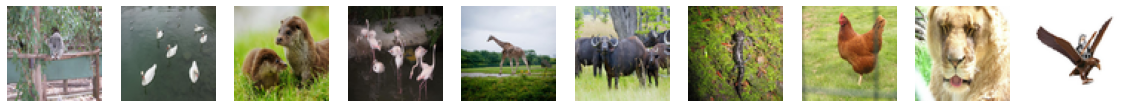

In [9]:

n = 10
idx = [rd.randint(0, x_test.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[idx[i]].reshape(64, 64,3)/255.)
    ax.grid(False)
    plt.axis('off')
plt.show()

In [10]:
def plot_training_analysis():
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [11]:


model = Sequential()

model.add(Conv2D(64,(3,3),input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(95,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 256)        0

# Our custom SIMCLR

In [12]:
#récupération d'un tenseur pour tester notre fonction d'augmentation
x_lab=tf.cast(x_lab, tf.float32)
#test_tensor=x_lab[1]
#test_tensor=np.array(test_tensor)


In [13]:
"""
avec cette fonction la boucle d'entrainement tourne 

def gen_augmentation(batch):
    aug_batch=[]
    for i in range(len(batch)) :
        x=np.array(batch[i],dtype='uint8')
        data={'image':x}#.reshape(64,64,3)/255.
        transforms = A.Compose([
                A.Sequential([
                #Rotate(limit=40),
                #HorizontalFlip(),
                #HueSaturationValue(hue_shift_limit=1, sat_shift_limit=1, val_shift_limit=1, p=0.5),
                    A.GaussianBlur(),
                    A.ColorJitter(),
                    A.CropAndPad(px=(0,20))
                    ])
                ])
        aug_data=transforms(**data)
        aug_img=aug_data['image'] 
        aug_batch.append(aug_img)   
    return np.array(aug_batch)
    """

"\navec cette fonction la boucle d'entrainement tourne \n\ndef gen_augmentation(batch):\n    aug_batch=[]\n    for i in range(len(batch)) :\n        x=np.array(batch[i],dtype='uint8')\n        data={'image':x}#.reshape(64,64,3)/255.\n        transforms = A.Compose([\n                A.Sequential([\n                #Rotate(limit=40),\n                #HorizontalFlip(),\n                #HueSaturationValue(hue_shift_limit=1, sat_shift_limit=1, val_shift_limit=1, p=0.5),\n                    A.GaussianBlur(),\n                    A.ColorJitter(),\n                    A.CropAndPad(px=(0,20))\n                    ])\n                ])\n        aug_data=transforms(**data)\n        aug_img=aug_data['image'] \n        aug_batch.append(aug_img)   \n    return np.array(aug_batch)\n    "

In [14]:
def gen_augmentation(batch):
#Cette fonction pioche une augmentation dans augmentations et l'applique au batch. Le papier montre qu'il est nécessaire d'avoir au minimum deux augmentations dans compose pour un apprentissage contrastif efficace. 
  augmentations=[A.ColorJitter(),A.HorizontalFlip(),A.GaussNoise(var_limit=0.001),A.Rotate(),A.ColorJitter(),A.VerticalFlip()]
  arr=[]
  for i in range(0,2): #remplacer 2 par n si on souhaite appliquer n augmentations simultanées
    arr.append(augmentations[randint(len(augmentations))])
  agm=A.Compose(arr)
  augm_batch=[]
  for img in batch:
    augm_im=agm(image=np.array(img, dtype='uint8'))
    augm_batch.append(augm_im['image'])
  return augm_batch


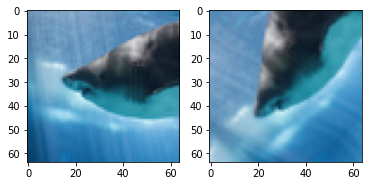

In [15]:
#cellule de test

#sélection et augmentation d'un batch
augm_batch=gen_augmentation(x_lab[0:20])

plt.subplot(1, 2, 1)
#affichage d'une image non augmentée
plt.imshow(x_lab[0]/255.)
plt.subplot(1, 2, 2)
#affichage de la même image augmentée
plt.imshow(augm_batch[0])

In [16]:
print(augm_batch[0][0][0][0])

84


In [17]:
def contrastive_loss_enzo(zi, zj, temp=0.5):
        ''' this loss is the modified torch implementation by M Diephuis here: https://github.com/mdiephuis/SimCLR/
        the inputs:
        xi, xj: image features extracted from a batch of images 2N, composed of N matching paints
        tau: temperature parameter
        normalize: normalize or not. seem to not be very useful, so better to try without.
        '''

        n_samples = 2*zi.shape[0]
        zi_norm = tf.math.l2_normalize(zi, axis=1)
        zj_norm = tf.math.l2_normalize(zj, axis=1)
        z_norm = tf.keras.backend.concatenate((zi_norm, zj_norm), axis=0)

        # Matrice de similarité
        similarities = tf.matmul(z_norm, z_norm, transpose_b=True) 
        similarities = tf.keras.backend.exp(similarities/temp)

        # Similarité négative
        mask = np.ones((n_samples, n_samples), dtype=bool)
        np.fill_diagonal(mask, False)
        neg = tf.reshape(tf.boolean_mask(similarities, mask), [n_samples, -1])
        neg = tf.math.reduce_sum(neg, axis=-1)

        # Similarité positive
        pos = tf.math.reduce_sum(tf.math.multiply(zi_norm, zj_norm), axis=-1)
        pos = tf.keras.backend.exp(pos / temp)
        pos = tf.keras.backend.concatenate((pos, pos), axis=0)

        loss = tf.math.divide(pos, neg)
        loss = -tf.keras.backend.log(loss)
        return tf.math.reduce_mean(loss)


In [18]:
def contrastive_loss(xi, xj,  tau=10, normalize=False):
        ''' this loss is the modified torch implementation by M Diephuis here: https://github.com/mdiephuis/SimCLR/
        the inputs:
        xi, xj: image features extracted from a batch of images 2N, composed of N matching paints
        tau: temperature parameter
        normalize: normalize or not. seem to not be very useful, so better to try without.
        '''

        x = tf.keras.backend.concatenate((xi, xj), axis=0)

        sim_mat = tf.keras.backend.dot(x, tf.keras.backend.transpose(x))

        if normalize:
            sim_mat_denom = tf.keras.backend.dot(tf.keras.backend.l2_normalize(x, axis=1).unsqueeze(1), tf.keras.backend.l2_normalize(x, axis=1).unsqueeze(1).T)
            sim_mat = sim_mat / sim_mat_denom.clamp(min=1e-16)

        sim_mat = tf.keras.backend.exp(sim_mat /tau)

        if normalize:
            sim_mat_denom = tf.keras.backend.l2_normalize(xi, dim=1) * tf.keras.backend.l2_normalize(xj, axis=1)
            sim_match = tf.keras.backend.exp(tf.keras.backend.sum(xi * xj, axis=-1) / sim_mat_denom / tau)
        else:
            sim_match = tf.keras.backend.exp(tf.keras.backend.sum(xi * xj, axis=-1) / tau)

        sim_match = tf.keras.backend.concatenate((sim_match, sim_match), axis=0)

        norm_sum = tf.keras.backend.exp(tf.keras.backend.ones(tf.keras.backend.shape(x)[0]) / tau)

        return tf.math.reduce_mean(-tf.keras.backend.log(sim_match / (tf.keras.backend.sum(sim_mat, axis=-1) - norm_sum)), name='contrastive_loss')

In [19]:
"""Layer-wise Adaptive Rate Scaling optimizer for large-batch training."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.platform import tf_logging
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import linalg_ops
from tensorflow.python.ops import logging_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import variables
from tensorflow.python.training import optimizer
from tensorflow.python.training import training_ops
from tensorflow.python.training import training_util

class LARSOptimizer(optimizer.Optimizer):
  """Layer-wise Adaptive Rate Scaling for large batch training.

  Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
  I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)

  Implements the LARS learning rate scheme presented in the paper above. This
  optimizer is useful when scaling the batch size to up to 32K without
  significant performance degradation. It is recommended to use the optimizer
  in conjunction with:
      - Gradual learning rate warm-up
      - Linear learning rate scaling
      - Poly rule learning rate decay
  """

  def __init__(self,
               learning_rate,           # use linear scaling rule
               momentum=0.9,            # suggested by paper
               weight_decay=0.0001,     # suggested by paper
               eeta = 0.001,
               epsilon = 1e-5,
               name="LARSOptimizer"):
    """Construct a new LARS Optimizer.

    Args:
      learning_rate: A `Tensor` or floating point value. The base learning rate.
      momentum: A floating point value. Momentum hyperparameter.
      weight_decay: A floating point value. Weight decay hyperparameter.
      name: Optional name prefix for variables and ops created by LARSOptimizer.

    Raises:
      ValueError: If a hyperparameter is set to a non-sensical value.
    """
    if momentum < 0.0:
      raise ValueError(
          "momentum should be positive: %s" % momentum)
    if weight_decay < 0.0:
      raise ValueError(
          "weight_decay should be positive: %s" % weight_decay)
    super(LARSOptimizer, self).__init__(use_locking=False, name=name)

    self._learning_rate = learning_rate
    self._momentum = momentum
    self._weight_decay = weight_decay
    self._eeta = eeta
    self._epsilon = epsilon
    self._name = name

  def _create_slots(self, var_list):
    for v in var_list:
      self._zeros_slot(v, "momentum", self._name)

  def _apply_dense(self, grad, var):
    scaled_lr = self._learning_rate
    decayed_grad = grad
    #tf_logging.info("LARS: apply dense: %s", var.name)
    if 'batch_normalization' not in var.name and 'bias' not in var.name:
      #tf_logging.info("LARS: apply dense, decay: %s", var.name)
      w_norm = linalg_ops.norm(var, ord=2)
      g_norm = linalg_ops.norm(grad, ord=2)
      trust_ratio = array_ops.where(
          math_ops.greater(w_norm, 0),
          array_ops.where(
              math_ops.greater(g_norm, 0),
              (self._eeta * w_norm /
               (g_norm + self._weight_decay * w_norm + self._epsilon)),
              1.0),
          1.0)
      trust_ratio = clip_ops.clip_by_value(trust_ratio, 0.0, 50)
      scaled_lr = self._learning_rate * trust_ratio
      decayed_grad = grad  + self._weight_decay * var

    decayed_grad = clip_ops.clip_by_value(decayed_grad, -10.0, 10.0)
    mom = self.get_slot(var, "momentum")
    return training_ops.apply_momentum(
        var, mom,
        scaled_lr,
        decayed_grad,
        self._momentum,
        use_locking=False,
        use_nesterov=False)

  def _resource_apply_dense(self, grad, var):
    scaled_lr = self._learning_rate
    decayed_grad = grad
    #tf_logging.info("LARS: resouce apply dense: %s", var.name)
    w_norm = linalg_ops.norm(var, ord=2)
    g_norm = linalg_ops.norm(grad, ord=2)
    if 'batch_normalization' not in var.name and 'bias' not in var.name:
      #tf_logging.info("LARS: apply dense, decay: %s", var.name)
      trust_ratio = array_ops.where(
          math_ops.greater(w_norm, 0),
          array_ops.where(
              math_ops.greater(g_norm, 0),
              (self._eeta * w_norm /
               (g_norm + self._weight_decay * w_norm + self._epsilon)),
              1.0),
          1.0)
      trust_ratio = clip_ops.clip_by_value(trust_ratio, 0.0, 50)
      scaled_lr = self._learning_rate * trust_ratio
      decayed_grad = grad + self._weight_decay * var

    decayed_grad = clip_ops.clip_by_value(decayed_grad, -10.0, 10.0)
    mom = self.get_slot(var, "momentum")
    return training_ops.resource_apply_momentum(
        var.handle, mom.handle,
        scaled_lr,
        decayed_grad,
        self._momentum,
        use_locking=False,
        use_nesterov=False)

In [20]:
x_unlab.shape

(8237, 64, 64, 3)

In [21]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.models import Model
def create_models():
  #define encoder (common part to our 2 models)
  #inputs = Input(shape=(x_unlab.shape[1:]), name='encoder_input')
  inputs = Input(shape=(64,64,3), name='encoder_input')
  x = Conv2D(filters=64,
             kernel_size=(3,3),
             activation='relu',
             padding='same')(inputs)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(128,(3,3),activation='relu', padding='same')(x)
  x = (MaxPooling2D(pool_size=(2,2)))(x)
  x = Conv2D(256,(3,3),activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(256,(3,3),activation='relu', padding='same')(x)
  h = MaxPooling2D(pool_size=(2,2))(x)
  encoder = Model(inputs, h, name='encoder')

  #layers added to train SIMCLR
  #projecteur = Sequential()

  latent_inputs = Input(shape=(4,4,256), name='projecteur_input')
  latent = GlobalAveragePooling2D()(latent_inputs)
  latent = Dense(1024, activation="relu")(latent)
  z = Dense(256, activation="sigmoid")(latent)
  projecteur = Model(latent_inputs, z, name='projecteur')
  outputs = projecteur(encoder(inputs))
  training_model = Model(inputs, outputs, name='SimCLR')
  
  #layer added to classify 
  cls_inputs = Input(shape=(4,4,256), name='cls_input')
  flat=Flatten()(cls_inputs)
  classification_layer=Dense(95, activation='softmax' )(flat)
  classifier=Model(cls_inputs, classification_layer, name="classifier")
  cls_output=classifier(encoder(inputs))
  classif_model=Model(inputs, cls_output, name='classif_model')
  
  return training_model, classif_model, encoder
 

In [22]:
training_model,classif_model, encoder=create_models()

training_model.summary()

Model: "SimCLR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 4, 4, 256)         960896    
                                                                 
 projecteur (Functional)     (None, 256)               525568    
                                                                 
Total params: 1,486,464
Trainable params: 1,486,464
Non-trainable params: 0
_________________________________________________________________


In [23]:
%%time 

training_model,classif_model, encoder=create_models()
 
#boucle custom training
batch_size=256
epochs=100
history=[]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = LARSOptimizer(learning_rate=0.3*batch_size/256)
loss_fn = contrastive_loss_enzo
training_model.compile(loss=loss_fn, optimizer=optimizer)
# Préparation des métriques pour le suivi de la performance du modèle.
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()
classif_model.compile(optimizer='Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[test_acc_metric])
steps_per_epoch = int(x_unlab.shape[0]/batch_size)
indices_unlab = np.arange(x_unlab.shape[0])

for epoch in range(epochs):
  cum_loss_value = 0

  if epoch %20 ==0 :
    encoder.trainable=False
    y_true=np.expand_dims(y_lab, 1)
    labels_pred=classif_model.predict(x_lab)
    accuracy=test_acc_metric(y_true, labels_pred)
    print("epoch", epoch, "Accuracy ", accuracy)
    encoder.trainable=True

  np.random.shuffle(indices_unlab)
  for step in range(steps_per_epoch):
    # Sélection des données du prochain batch
    x_batch=x_unlab[indices_unlab[step*batch_size: (step+1)*batch_size]]
    ##y_batch = y_lab[step*batch_size: (step+1)*batch_size]

    # Etape nécessaire pour comparer y_batch à la sortie du réseau
   ## y_batch = np.expand_dims(y_batch, 1)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:
      #print(np.array(x_batch).shape)
      # Application du réseau aux données d'entrée
      x_batch1=gen_augmentation(x_batch)
      x_batch2=gen_augmentation(x_batch)
      
      tf_xbatch1=tf.convert_to_tensor(x_batch1)
      tf_xbatch2=tf.convert_to_tensor(x_batch2)
      
      z_pred1 = training_model(tf_xbatch1) #, training=True #avec dataaugm1
      z_pred2 = training_model(tf_xbatch2) #, training=True # avec dataaugm2
      # Calcul de la fonction de perte sur ce batch

      loss_value = loss_fn(z_pred1, z_pred2)
      history.append(loss_value)
      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, training_model.trainable_weights)
      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, training_model.trainable_weights))

     # cum_loss_value = cum_loss_value + loss_value
  print("epoch", epoch, "Loss", loss_value)
 


epoch 0 Accuracy  tf.Tensor(0.010526316, shape=(), dtype=float32)
epoch 0 Loss tf.Tensor(5.944256, shape=(), dtype=float32)
epoch 1 Loss tf.Tensor(5.603615, shape=(), dtype=float32)
epoch 2 Loss tf.Tensor(5.4801164, shape=(), dtype=float32)
epoch 3 Loss tf.Tensor(5.496808, shape=(), dtype=float32)
epoch 4 Loss tf.Tensor(5.3195915, shape=(), dtype=float32)
epoch 5 Loss tf.Tensor(5.172963, shape=(), dtype=float32)
epoch 6 Loss tf.Tensor(5.348249, shape=(), dtype=float32)
epoch 7 Loss tf.Tensor(5.20096, shape=(), dtype=float32)
epoch 8 Loss tf.Tensor(5.3072534, shape=(), dtype=float32)
epoch 9 Loss tf.Tensor(5.1658015, shape=(), dtype=float32)
epoch 10 Loss tf.Tensor(5.249814, shape=(), dtype=float32)
epoch 11 Loss tf.Tensor(5.47365, shape=(), dtype=float32)
epoch 12 Loss tf.Tensor(5.360157, shape=(), dtype=float32)
epoch 13 Loss tf.Tensor(5.346066, shape=(), dtype=float32)
epoch 14 Loss tf.Tensor(5.139184, shape=(), dtype=float32)
epoch 15 Loss tf.Tensor(5.0410476, shape=(), dtype=float3

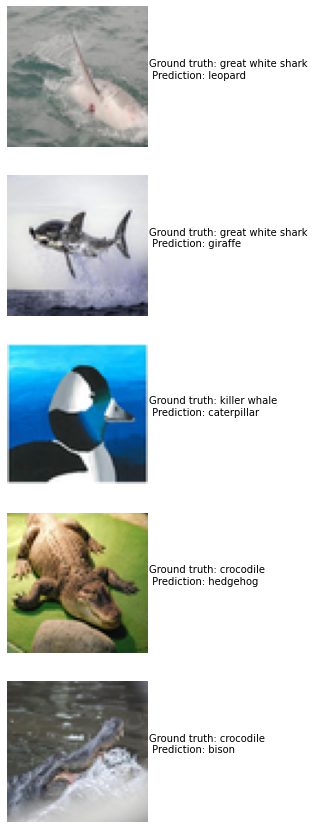

In [24]:
#print(x_test.shape)
preds=classif_model.predict(x_test)
#print(preds.shape)
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
for i in range(5):
  axes[i].imshow(x_test[i*20]/255.)
  true_text = CLASSES[int(y_test[i*20])]
  pred_text = CLASSES[np.argmax(preds[i*20])]
  axes[i].axis('off')
  axes[i].text(64, 32, 'Ground truth: ' + true_text + '\n' + ' Prediction: ' + pred_text)

In [25]:
encoder.trainable=False
classif_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[test_acc_metric])
classif_model.fit(x_lab, y_true, epochs=30)


Epoch 1/30
15/15 [==============================] - 1s 12ms/step - loss: 20.8808 - sparse_categorical_accuracy: 0.0102
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 13.6705 - sparse_categorical_accuracy: 0.0211
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 10.5724 - sparse_categorical_accuracy: 0.0442
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 8.4621 - sparse_categorical_accuracy: 0.0589
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 6.9566 - sparse_categorical_accuracy: 0.1074
Epoch 6/30
15/15 [==============================] - 0s 11ms/step - loss: 5.7749 - sparse_categorical_accuracy: 0.1579
Epoch 7/30
15/15 [==============================] - 0s 11ms/step - loss: 4.8541 - sparse_categorical_accuracy: 0.1937
Epoch 8/30
15/15 [==============================] - 0s 11ms/step - loss: 4.0639 - sparse_categorical_accuracy: 0.2653
Epoch 9/30
15/15 [==============================] - 0

In [26]:

classif_model.evaluate(x_test, np.expand_dims(y_test,1))

90/90 [==============================] - 1s 11ms/step - loss: 11.4064 - sparse_categorical_accuracy: 0.0446


[11.406363487243652, 0.04456140473484993]

In [27]:
preds=classif_model.predict(x_test)


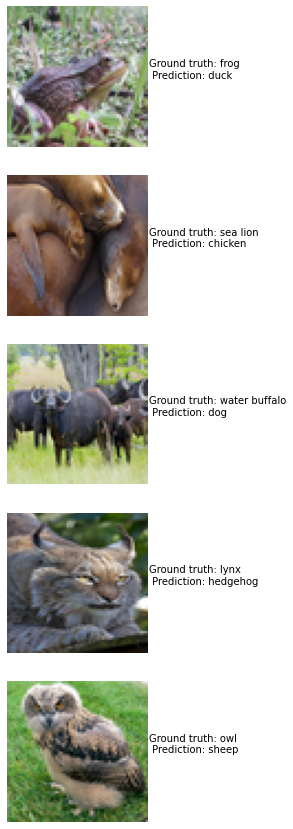

In [28]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
indexes=np.random.choice(len(y_test), 5)
for i in range(5):
  axes[i].imshow(x_test[indexes[i]]/255.)
  true_text = CLASSES[int(y_test[indexes[i]])]
  pred_text = CLASSES[np.argmax(preds[indexes[i]])]
  axes[i].axis('off')
  axes[i].text(64, 32, 'Ground truth: ' + true_text + '\n' + ' Prediction: ' + pred_text)
